In [17]:
# Initialize plotting:
%matplotlib inline
# Import all relevant packages
import PIL
from PIL import Image
import scipy.ndimage
import numpy as np, matplotlib.pyplot as plt
import scipy.stats
import scipy as sp
from ipywidgets import interact
from scipy.integrate import solve_ivp

from importlib import reload
from IPython.display import clear_output, display

# Suppress some logging messages in Pillow (Python Imaging Library)
import logging; logging.getLogger('PIL').setLevel(logging.ERROR)  # Suppress PIL messages


Here we use the provided code to denoise images based on the following model:

\begin{gather*}
  E[u] = \int\frac{1}{p}\bigl(|\vec{\nabla}u|^2 + ϵ_p\bigr)^{p/2} 
       + \frac{λ}{q}\int\bigl((u - d)^2 + ϵ_q\bigr)^{q/2},\\
  E'[u] = -\vec{\nabla}\cdot\Bigl(
    (\vec{\nabla} u) \bigl(
      |\vec{\nabla}u|^2 + ϵ_p
    \bigr)^{(p-2)/2}
  \Bigr) 
  + λ(u - d)\bigl((u - d)^2 + ϵ_q\bigr)^{(q-2)/2}\\
\end{gather*}

We will focus here on the case $p=q=1$.



In [19]:
%matplotlib inline
from IPython.display import clear_output
import numpy as np, matplotlib.pyplot as plt
import denoise

eps = np.finfo(float).eps+.001

im = denoise.Image()
d = denoise.Denoise(image=im, sigma=0.4, lam=0.1, mode="reflect", p=1, q=1, eps_p=eps, eps_q=eps)

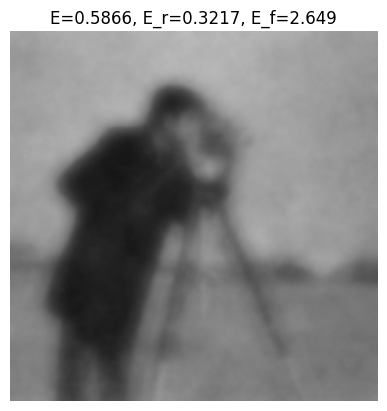

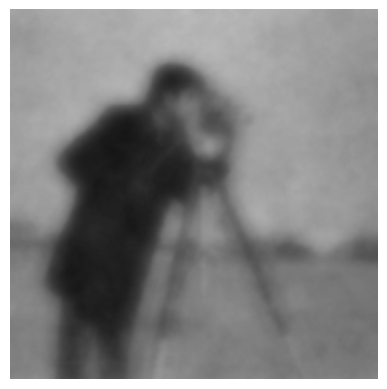

In [22]:
u = d.minimize(tol=1e-4, plot=True)
im.show(u)

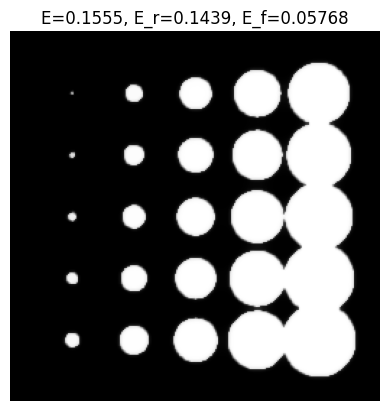

array([[ 2.95184903e-07, -2.40591350e-07, -1.23248520e-07, ...,
        -1.96787136e-07, -1.32326603e-06, -1.37874781e-06],
       [ 3.27322210e-07, -5.73164423e-08, -2.33414186e-08, ...,
        -7.35856601e-09, -1.43626646e-06, -1.05432867e-06],
       [ 6.72456094e-07, -9.41879363e-07, -6.78257198e-07, ...,
        -6.20615483e-07, -3.57533904e-07, -4.85040438e-07],
       ...,
       [-6.65487333e-07,  3.16167806e-07, -5.51864401e-07, ...,
        -4.64525606e-07, -3.70448172e-07, -2.83967934e-06],
       [-1.34045179e-09, -7.48421210e-07, -9.00320947e-07, ...,
        -7.15013268e-08, -1.91341947e-06,  4.39667715e-06],
       [-1.01052258e-06,  3.29342856e-08, -1.91956163e-07, ...,
         2.04574382e-06,  2.72599045e-06,  4.89820564e-06]])

In [ ]:
N = 256
Nxy = (N, N)
x, y = np.meshgrid(*[np.arange(_N)/_N for _N in Nxy], sparse=True)

Nc = 5
np.ogrid[1:Nc+2, 1:Nc+2]
_x, _y = np.ogrid[1:Nc+1, 1:Nc+1]
centers = np.ravel((_x + 1j*_y)/(Nc+1))
radii = np.linspace(0, 1/2/Nc, Nc**2+1)[1:]
print(radii)
circles = list(zip(centers, radii))

u = 0*x + 0*y
for z0, r in circles:
    u = np.maximum(u, np.where(abs(x+1j*y - z0) < r, 1, 0))

im = denoise.Image(data=u)
d = denoise.Denoise(im, sigma=0, lam=0.2, p=1, q=1)
d.minimize(plot=True, tol=1e-5)

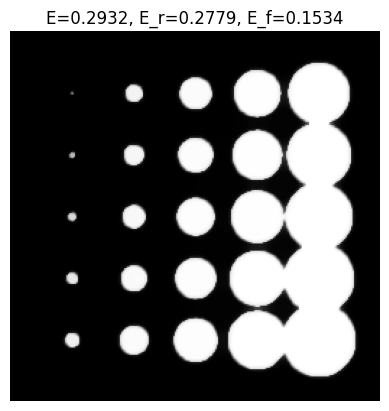

array([[-4.37372878e-06, -4.37469244e-06, -4.07814622e-06, ...,
         1.19185114e-06,  2.62500075e-06,  2.00563399e-06],
       [-4.09309506e-06, -3.21301715e-06, -2.01721932e-06, ...,
         2.10878447e-06,  2.47981643e-06,  2.90559185e-06],
       [-1.29902318e-06, -1.61004921e-06, -1.94440642e-06, ...,
         2.03997842e-06,  2.62797097e-06,  1.69834397e-06],
       ...,
       [ 3.28752537e-07,  9.04654967e-08, -4.33796013e-08, ...,
        -2.03265075e-07, -2.13221191e-06, -1.31446404e-06],
       [ 9.48604936e-07, -4.02052843e-08, -7.72050785e-08, ...,
        -3.36932165e-06, -3.51988625e-06, -2.28790416e-06],
       [ 2.00734821e-06,  7.22996706e-07,  1.09667840e-06, ...,
        -9.12116473e-07, -3.85288083e-06, -3.98791830e-06]])

In [ ]:

im = denoise.Image(data=u)
d = denoise.Denoise(im, sigma=0, lam=0.1, p=1, q=1)
d.minimize(plot=True, tol=1e-5)

This does not seem to do much:we expect that the smallest dots should vanish.  What is going wrong here is that I susspect that the minimizer is getting stuck on a local minimum.  This is a common problem with gradient descent minimizers. 



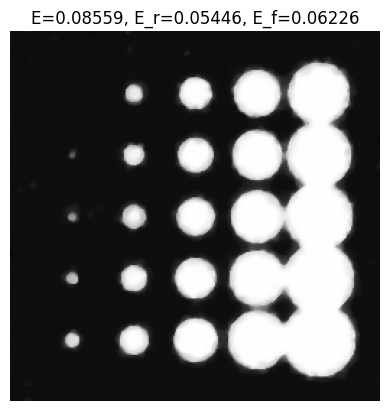

In [15]:
d = denoise.Denoise(im, sigma=0, lam=0.5, p=1, q=1)
u = d.minimize(np.random.random(u.shape), tol=1e-4, plot=True, options=dict(maxcor=50))

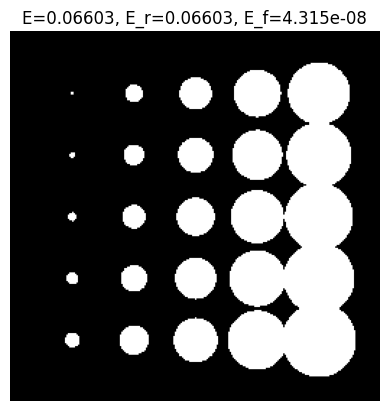

In [16]:
# Custom callback function

def callback(y, plot=False):
    u = d.unpack(y)
    E, E_r, E_f = d.get_energy(u, parts=True)

    msg = f"E={E:.4g}, E_r={E_r:.4g}, E_f={E_f:.4g}"
    if plot:
        import IPython.display

        fig = plt.gcf()
        ax = plt.gca()
        ax.cla()
        IPython.display.clear_output(wait=True)
        im.show(u, ax=ax)
        ax.set(title=msg)
        IPython.display.display(fig)
    else:
        print(msg)

u = d.minimize(plot=True, callback=callback, tol=1e-5)